# Sharp-wave ripple detection for DLS replay reviews

In [2]:

import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.signal import find_peaks, argrelmin
from scipy.signal import butter, filtfilt, hilbert
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt


In [3]:

# ---------------------------------------------------------------------------------------------------------------------
# Load data


def find_sync_file(mouse_file, animal_dat_path):
    """Finds sync files and loads POST SLEEP timestamps"""
    animal_dat_path = str(animal_dat_path) + os.path.sep
    mouse_file = str(mouse_file)

    ## find sync file:
    for item in os.listdir(animal_dat_path):
        if mouse_file.split("_")[0] in item:
            if mouse_file.split("_")[1] == item[-1]:
                for folder in os.listdir(animal_dat_path + item):
                    if (
                        folder.split("_")[0].split("g")[-1]
                        == mouse_file.split("_")[-1]
                    ):
                        current_animals_video_path = (
                            os.path.join(animal_dat_path + item, folder)
                            + "/video/tracking/"
                        )
                        current_animals_behav_sync_path = (
                            os.path.join(animal_dat_path + item, folder)
                            + "/behav_sync/"
                        )
                        for stage in os.listdir(
                            current_animals_behav_sync_path
                        ):
                            if "postsleep" in stage or "post_sleep" in stage:
                                sync_path = (
                                    current_animals_behav_sync_path
                                    + stage
                                    + "/"
                                )

    if mouse_file == "148_2_2":
        sync_df = pd.read_csv(
            sync_path + r"Postsleep_Ephys_Camera_sync.csv", encoding="cp1252"
        )
    else:
        sync_df = pd.read_csv(sync_path + r"Postsleep_Ephys_Camera_sync.csv")

    return sync_df


def load_lfp_data(subject_session, dir_lfp, dir_subject):
    """
    Load LFP data and timestamps from a given mouse directory.

    Parameters
    ----------
    subject_dir : str
        Path to the mouse folder containing .npy LFP channels and a timestamps CSV.

    Returns
    -------
    timestamps : np.ndarray
        1D array of timestamps.
    lfp_all : np.ndarray
        2D array (channels x samples) of LFP data.
    channel_names : list[str]
        List of channel file names loaded.
    """
    subject_dir = Path(dir_lfp) / subject_session
    files = sorted(os.listdir(subject_dir))
    data_channels = []
    channel_names = []
    timestamps = None

    for f in files:
        path = os.path.join(subject_dir, f)
        if "timestamps" in f:
            timestamps_df = pd.read_csv(path)
        elif f.endswith(".npy"):
            try:
                data = np.load(path)
            except Exception:
                data = np.load(path, allow_pickle=True)
            data_channels.append(data)
            channel_names.append(f)

    lfp = np.vstack(data_channels)

    assert lfp.shape[1] == timestamps_df.shape[0]

    # Select post sleep LFP
    # this implicitly loads the POST SLEEP camera timestamps
    sync_df = find_sync_file(
        mouse_file=subject_session, animal_dat_path=dir_subject
    )
    ts_ephys_post_sleep_start = sync_df.Camera_time_Ephys_Aligned[0]
    ts_ephys_post_sleep_mask = (
        timestamps_df.ephys_timestamp > ts_ephys_post_sleep_start
    )
    timestamps_df = timestamps_df[ts_ephys_post_sleep_mask]
    lfp = lfp[:, ts_ephys_post_sleep_mask]

    return timestamps_df, lfp, channel_names


In [4]:

# ---------------------------------------------------------------------------------------------------------------------
# Preprocess data


def butter_bandpass_filter(
    data, lowcut, highcut, fs, order_hp=2, order_lp=4, axis=-1
):
    """
    Apply band-pass filter (highpass + lowpass Butterworth) to single or multi-channel data.

    Parameters
    ----------
    data : np.ndarray
        LFP array of shape (n_channels, n_samples) or (n_samples,)
    lowcut, highcut : float
        Frequency bounds in Hz.
    fs : float
        Sampling frequency in Hz.
    order_hp, order_lp : int
        Filter orders for high- and low-pass filters.
    axis : int
        Axis along which to filter (default: last, i.e. time).

    Returns
    -------
    filtered_band : np.ndarray
        Filtered signal, same shape as input.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # High-pass
    b_hp, a_hp = butter(order_hp, low, btype="high", analog=False)
    filtered_hp = filtfilt(b_hp, a_hp, data, axis=axis)

    # Low-pass
    b_lp, a_lp = butter(order_lp, high, btype="low", analog=False)
    filtered_band = filtfilt(b_lp, a_lp, filtered_hp, axis=axis)

    return filtered_band


def analytic_amplitude(data, axis=-1):
    """Compute absolute value of Hilbert transform along axis."""
    return np.abs(hilbert(data, axis=axis))


def smooth_signal(data, sigma_ms=12.5, fs=2500, axis=-1):
    """
    Smooth the signal using a Gaussian kernel with std `sigma_ms` milliseconds.
    Works along the specified axis.
    """
    sigma_samples = sigma_ms * fs / 1000.0  # convert ms → samples
    return gaussian_filter1d(
        data, sigma=sigma_samples, axis=axis, mode="reflect"
    )


def average_channels(data, axis=0):
    """
    Average across channels (default axis=0 for chan × time input).
    """
    return np.mean(data, axis=axis)


def zscore_signal(data, axis=-1):
    """
    Z-score the signal along the specified axis.
    Returns standardized signal and mean/std used.
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True)
    z = (data - mean) / std
    return z


def preprocess_lfp_for_ripple_detection(lfp, lowcut=150, highcut=250, fs=2500):
    lfp_filt = butter_bandpass_filter(
        data=lfp, lowcut=lowcut, highcut=highcut, fs=fs, axis=-1
    )
    lfp_abs = analytic_amplitude(data=lfp_filt)
    lfp_smooth = smooth_signal(data=lfp_abs, fs=fs)
    lfp_avg = average_channels(data=lfp_smooth)
    lfp_z = zscore_signal(data=lfp_avg)
    return lfp_filt, lfp_z


In [5]:

# ---------------------------------------------------------------------------------------------------------------------
# Peak detection & limit event intervals with local minima


def find_local_minima_boundaries(signal_1d, peak_idx, search_window=100, 
                                  baseline=0.0):
    """
    Find local minima before and after a peak by detecting where derivative changes sign.
    Much faster than argrelmin for local searches.
    
    Parameters
    ----------
    signal_1d : array
        1D signal data
    peak_idx : int
        Index of detected peak
    search_window : int
        Maximum distance to search for minima (in samples)
    baseline : float
        If no minima found, fall back to baseline crossing
        
    Returns
    -------
    start_idx, end_idx : int, int
        Indices of local minima defining event boundaries
    """
    n = len(signal_1d)
    
    # Define search boundaries
    left_bound = max(0, peak_idx - search_window)
    right_bound = min(n - 1, peak_idx + search_window)
    
    # Search left: find where signal stops decreasing (derivative changes from negative to positive)
    start_idx = peak_idx - 1
    while start_idx > left_bound:
        if signal_1d[start_idx] < signal_1d[start_idx - 1]:
            # Found a local minimum (next point is higher)
            break
        start_idx -= 1
    
    # If we hit the boundary without finding a minimum, fall back to baseline
    if start_idx == left_bound:
        start_idx = peak_idx
        while start_idx > left_bound and signal_1d[start_idx] > baseline:
            start_idx -= 1
    
    # Search right: find where signal stops decreasing (derivative changes from negative to positive)
    end_idx = peak_idx + 1
    while end_idx < right_bound:
        if signal_1d[end_idx] < signal_1d[end_idx + 1]:
            # Found a local minimum (next point is higher)
            break
        end_idx += 1
    
    # If we hit the boundary without finding a minimum, fall back to baseline
    if end_idx == right_bound:
        end_idx = peak_idx
        while end_idx < right_bound and signal_1d[end_idx] > baseline:
            end_idx += 1
    
    return start_idx, end_idx


def detect_ripples(zsignal, fs=2500, threshold=3.0, axis=-1, 
                   use_local_minima=True, search_window=100):
    """
    Detect ripple events based on z-scored signal exceeding threshold.
    Extract start, end, and peak metrics for each event.
    
    Parameters
    ----------
    zsignal : 1D or ND array
        Z-scored, smoothed, averaged ripple-band signal.
    fs : float
        Sampling frequency in Hz.
    threshold : float
        Detection threshold in standard deviations.
    axis : int
        Axis along which to detect (default: -1).
    use_local_minima : bool
        If True, use local minima to define event boundaries.
        If False, use simple baseline crossing (original method).
    search_window : int
        Maximum distance (in samples) to search for local minima around each peak.
        Default: 100 samples (~40ms at 2500 Hz)
        
    Returns
    -------
    ripples_df : pd.DataFrame
        Table of detected ripple events with:
        ['peak_idx', 'peak_amp', 'start_idx', 'end_idx',
         'start_time', 'peak_time', 'end_time', 'duration_ms']
    """
    # Make sure we're working on a 1D signal (after averaging across channels)
    signal_1d = np.squeeze(zsignal)
    assert signal_1d.ndim == 1, "Ripple detection expects a 1D signal (e.g., averaged LFP)."
    
    # Find peaks above threshold
    peak_inds, props = find_peaks(signal_1d, height=threshold)
    
    ripples = []
    mean_level = 0.0  # baseline for crossings
    
    for peak_idx in peak_inds:
        if use_local_minima:
            # Use local minima to define boundaries
            start_idx, end_idx = find_local_minima_boundaries(
                signal_1d, 
                peak_idx, 
                search_window=search_window,
                baseline=mean_level
            )
        else:
            # Original method: simple baseline crossing
            # Search backwards for start crossing (signal falls below mean)
            start_idx = peak_idx
            while start_idx > 0 and signal_1d[start_idx] > mean_level:
                start_idx -= 1
            
            # Search forward for end crossing
            end_idx = peak_idx
            while end_idx < len(signal_1d) - 1 and signal_1d[end_idx] > mean_level:
                end_idx += 1
        
        peak_amp = signal_1d[peak_idx]
        duration_ms = (end_idx - start_idx) / fs * 1000.0
        
        ripples.append({
            "peak_idx": peak_idx,
            "peak_amp": peak_amp,
            "start_idx": start_idx,
            "end_idx": end_idx,
            "start_time": start_idx / fs,
            "peak_time": peak_idx / fs,
            "end_time": end_idx / fs,
            "duration_ms": duration_ms
        })
    
    return pd.DataFrame(ripples)


In [6]:

# ---------------------------------------------------------------------------------------------------------------------
# PLOTS


# def plot_ripple_overview(
#     lfp_z, ripples_df, fs=2500, time_window=None, ax=None
# ):
#     """
#     Plot the z-scored ripple-band signal with all detected ripple peaks
#     within an optional time window.

#     Parameters
#     ----------
#     lfp_z : np.ndarray
#         Z-scored ripple-band signal (1D).
#     ripples_df : pd.DataFrame
#         Detected ripple events.
#     fs : float
#         Sampling rate (Hz).
#     time_window : tuple[float, float] or None
#         (start_time, end_time) in seconds to zoom into.
#         If None, plot the full signal.
#     ax : matplotlib axis or None
#         Axis to plot into.
#     """
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(10, 4))

#     t = np.arange(len(lfp_z)) / fs

#     # Apply time window if given
#     if time_window is not None:
#         tmask = (t >= time_window[0]) & (t <= time_window[1])
#         t = t[tmask]
#         lfp_z = lfp_z[tmask]
#         peaks_in_window = ripples_df[
#             (ripples_df["peak_time"] >= time_window[0])
#             & (ripples_df["peak_time"] <= time_window[1])
#         ]
#     else:
#         peaks_in_window = ripples_df

#     ax.plot(t, lfp_z, color="black", lw=0.8)
#     ax.scatter(
#         peaks_in_window["peak_time"],
#         [lfp_z[int(pt * fs)] for pt in peaks_in_window["peak_time"]],
#         color="red",
#         s=25,
#         label="Ripple peaks",
#     )

#     ax.set_xlabel("Time (s)")
#     ax.set_ylabel("Z-scored ripple-band amplitude")
#     ax.set_title("Ripple overview")
#     ax.legend()
#     return ax
def plot_ripple_overview(lfp_z, ripples_df, fs, time_window=None, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))

    n_samples = len(lfp_z)
    total_time = n_samples / fs
    t = np.arange(n_samples) / fs

    # restrict to given time window
    if time_window is not None:
        tmin, tmax = time_window
        idx_min, idx_max = int(tmin * fs), int(tmax * fs)
        ax.plot(t[idx_min:idx_max], lfp_z[idx_min:idx_max], color="black", lw=0.8)
        peaks_in_window = ripples_df[
            (ripples_df["peak_time"] >= tmin) & (ripples_df["peak_time"] <= tmax)
        ]
    else:
        ax.plot(t, lfp_z, color="black", lw=0.8)
        peaks_in_window = ripples_df

    # --- filter peaks to valid sample range ---
    valid_peaks = peaks_in_window[
        (peaks_in_window["peak_time"] >= 0)
        & (peaks_in_window["peak_time"] * fs < n_samples)
    ]

    # plot peaks safely
    ax.scatter(
        valid_peaks["peak_time"],
        [lfp_z[int(pt * fs)] for pt in valid_peaks["peak_time"]],
        color="red",
        s=25,
        label="Ripple peaks",
    )

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Z-scored ripple-band amplitude")
    ax.legend()

    return ax


def plot_single_ripple(
    lfp_z, ripples_df, event_idx, fs=2500, window_ms=100, ax=None
):
    """
    Plot one ripple event, marking start, peak, and end times.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    else:
        fig = None

    row = ripples_df.iloc[event_idx]

    # Cast to int to avoid TypeError
    peak_idx = int(row["peak_idx"])
    start_idx = int(row["start_idx"])
    end_idx = int(row["end_idx"])

    half_window = int(window_ms / 1000 * fs / 2)
    start = max(0, peak_idx - half_window)
    end = min(len(lfp_z), peak_idx + half_window)

    t = np.arange(start, end) / fs
    seg = lfp_z[start:end]

    ax.plot(t, seg, color="black", lw=1)
    ax.axvline(start_idx / fs, color="blue", ls="--", lw=1, label="Start")
    ax.axvline(peak_idx / fs, color="red", ls="-", lw=1, label="Peak")
    ax.axvline(end_idx / fs, color="green", ls="--", lw=1, label="End")

    ax.set_title(
        f"Ripple #{event_idx} — Duration: {(end_idx - start_idx)/fs*1000:.1f} ms"
    )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("LFP (z-score)")
    ax.legend()

    if fig:
        plt.tight_layout()
        return fig, ax
    else:
        return ax


def ripple_triggered_average(lfp_sw, ripple_df, fs=2500, window_ms=100):
    """
    Compute ripple-triggered average of sharp-wave filtered LFP.
    Returns time vector and averaged signal across ripples.
    """
    n_ch, n_samples = lfp_sw.shape
    half_window = int(window_ms / 1000 * fs)
    snippets = []

    for _, r in ripple_df.iterrows():
        pk = int(r["peak_idx"])
        start = max(0, pk - half_window)
        end = min(n_samples, pk + half_window)
        if end - start == 2 * half_window:
            snippets.append(lfp_sw[:, start:end])

    if not snippets:
        return None, None

    snippets = np.stack(snippets, axis=0)  # (n_ripples, n_ch, win)
    avg = np.mean(snippets, axis=0)  # (n_ch, win)
    t = np.linspace(-window_ms, window_ms, avg.shape[1])
    return t, avg


def plot_ripple_triggered_lfp(
    lfp_z, lfp_sw, ripple_df, fs=2500, xlim=None, offset=200
):
    """
    Create two vertically stacked plots:
      1. Z-scored ripple-band amplitude with ripple markers
      2. Sharp-wave-band filtered LFP (all channels, stacked)
    Ripples within the xlim are highlighted on both plots.

    Parameters
    ----------
    lfp_z : np.ndarray
        Z-scored ripple-band amplitude (1D).
    lfp_sw : np.ndarray
        Sharp-wave-band filtered LFP (n_channels x n_samples).
    ripple_df : pd.DataFrame
        Ripple detection DataFrame.
    fs : float
        Sampling rate (Hz).
    xlim : tuple[float,float] or None
        Time window (s) to display. If None, full signal.
    offset : float
        Vertical offset between channels in SW plot.
    """
    t = np.arange(lfp_z.shape[-1]) / fs

    fig, (ax1, ax2) = plt.subplots(
        2,
        1,
        figsize=(12, 6),
        sharex=True,
        gridspec_kw={"height_ratios": [1, 2]},
    )

    # === Top: z-scored ripple amplitude ===
    ax1.plot(t, lfp_z, color="black", lw=0.8)
    peaks_in_window = (
        ripple_df
        if xlim is None
        else ripple_df.query(f"{xlim[0]} <= peak_time <= {xlim[1]}")
    )
    ax1.scatter(
        peaks_in_window["peak_time"],
        [lfp_z[int(pt * fs)] for pt in peaks_in_window["peak_time"]],
        color="red",
        s=20,
        label="Ripple peaks",
    )
    ax1.set_ylabel("Ripple z-score")
    ax1.legend()
    ax1.set_title("Ripple-band envelope and SW-filtered LFPs")

    # === Bottom: Sharp-wave filtered LFP (stacked) ===
    for i, ch in enumerate(lfp_sw):
        ax2.plot(t, ch + i * offset, color="gray", lw=0.6)

    # Ripple markers
    for pt in peaks_in_window["peak_time"]:
        ax2.axvline(pt, color="red", lw=0.5, alpha=0.5)

        # Ripple start/end
    for pt in peaks_in_window["start_time"]:
        ax2.axvline(pt, color="b", lw=0.5, alpha=0.5)
    for pt in peaks_in_window["end_time"]:
        ax2.axvline(pt, color="b", lw=0.5, alpha=0.5)

    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Sharp-wave LFP (offset)")
    if xlim:
        ax2.set_xlim(xlim)

    plt.tight_layout()
    return fig, (ax1, ax2)



In [7]:

def detect_spw_events(lfp, fs=2500, lowcut=5, highcut=40, z_thresh=2.5, 
                      min_dur_ms=20, max_dur_ms=400):

    # 1. Filter LFP
    filtered = butter_bandpass_filter(
        lfp, lowcut=lowcut, highcut=highcut, fs=fs, order_hp=2, order_lp=4, axis=-1
    )

    # 2. Z-score
    zsig = (filtered - np.mean(filtered)) / np.std(filtered)

    # 3. Find peaks above threshold
    peak_idxs, _ = find_peaks(zsig, height=z_thresh)

    events = []
    min_samples = int(min_dur_ms / 1000 * fs)
    max_samples = int(max_dur_ms / 1000 * fs)

    # 4. Find event boundaries for each peak
    for p in peak_idxs:
        # Go backward until signal drops below 0
        start = p
        while start > 0 and zsig[start] > 0:
            start -= 1
        # Forward until below 0
        end = p
        while end < len(zsig) - 1 and zsig[end] > 0:
            end += 1

        dur = end - start
        if min_samples <= dur <= max_samples:
            events.append({
                'peak_idx': p,
                'peak_amp': zsig[p],
                'start_idx': start,
                'end_idx': end,
                'start_time': start / fs,
                'peak_time': p / fs,
                'end_time': end / fs,
                'duration_ms': dur / fs * 1000
            })

    return pd.DataFrame(events)


def find_spw_overlap(ripple_row, df_spw, fs=2500):
    """
    Annotate one ripple event with overlapping SPW info.
    Returns dict with overlap index, peak offset, and overlap duration (ms).
    """
    r_start = ripple_row['start_time']
    r_end = ripple_row['end_time']
    r_peak = ripple_row['peak_time']

    # Find SPWs that overlap in time
    overlapping = df_spw[
        (df_spw['end_time'] >= r_start) &
        (df_spw['start_time'] <= r_end)
    ]
    
    if len(overlapping) == 0:
        return pd.Series({'spw_index': None, 'peak_offset_ms': np.nan, 'overlap_ms': 0.0})
    
    # Pick the one with the closest peak to the ripple peak
    closest = overlapping.iloc[(overlapping['peak_time'] - r_peak).abs().argsort().iloc[0]]
    
    # Compute peak offset (ms)
    peak_offset_ms = (closest['peak_time'] - r_peak) * 1000
    
    # Compute overlap (ms)
    overlap_start = max(r_start, closest['start_time'])
    overlap_end = min(r_end, closest['end_time'])
    overlap_ms = max(0, (overlap_end - overlap_start) * 1000)

    return pd.Series({
        'spw_index': closest.name,
        'peak_offset_ms': peak_offset_ms,
        'overlap_ms': overlap_ms
    })


## Analysis

### Definitions

In [8]:
dir_lfp = Path(
    "/ceph/sjones/projects/sequence_squad/revision_data/emmett_revisions/oscillations/hippocampus_lfp/extracted_LFP/"
)
dir_subject = Path(
    "/ceph/sjones/projects/sequence_squad/revision_data/organised_data/animals/"
)
dir_output = Path(
    "/ceph/sjones/projects/sequence_squad/revision_data/emmett_revisions/oscillations/hippocampus_lfp/processed_ripples/"
)
dir_output.mkdir(exist_ok=True)

fs = 2500
ripple_low_cut = 150
ripple_high_cut = 250



### Loop subject sessions -> save ripple detection dataframe

In [9]:
# # List sessions to process
# for subject_session in sorted(os.listdir(dir_lfp)):
#     temp_path = Path(dir_lfp) / subject_session
#     print(temp_path)

In [10]:
from tqdm import tqdm

for subject_session in tqdm(sorted(os.listdir(dir_lfp))[::-1]):
    print(subject_session)

    r_df_path = dir_output / (subject_session + ".csv")
    if r_df_path.exists():
        print("--> exists. skipping")
        # continue
    
    # Load LFP for one subject/session
    try:
        _, lfp, _ = load_lfp_data(
            subject_session=subject_session,
            dir_lfp=dir_lfp,
            dir_subject=dir_subject,
        )
    except AssertionError:
        print("--> ts mismatch? skipping.")
        continue
    
    # Preprocess LFP
    lfp_ripple, lfp_z = preprocess_lfp_for_ripple_detection(
        lfp=lfp, lowcut=ripple_low_cut, highcut=ripple_high_cut, fs=fs
    )
    # Detect ripples
    if r_df_path.exists():
        ripples_minima = pd.read_csv(r_df_path)
    else:
        ripples_minima = detect_ripples(
            lfp_z,
            fs=fs,
            threshold=3.0,
            use_local_minima=True,
            search_window=int(0.15 * fs),  # 150ms search window
            # minima_order=1,
        )
        
    # Save df
    ripples_minima.to_csv(dir_output / (subject_session + "__ripples.csv"))

    # Detect sharp waves
    sw_df = detect_spw_events(
        -lfp[2,:], 
        fs=fs, 
        lowcut=5, 
        highcut=40, 
        z_thresh=3, 
        min_dur_ms=20, 
        max_dur_ms=400,
    )

    # Save df
    sw_df.to_csv(dir_output / (subject_session + "__sharpwaves.csv"))

    # Detect overlap
    ripples_minima[['spw_index', 'spw_peak_offset_ms', 'spw_ripple_overlap_ms']] = ripples_minima.apply(
        find_spw_overlap, axis=1, df_spw=sw_df
    )
    ripples_minima['has_spw'] = ripples_minima['spw_index'].notna()

    print("ripples:", ripples_minima.shape[0], "spw:", sw_df.shape[0], "overlap:", ripples_minima['has_spw'].value_counts())

    # Save overlap df
    ripples_minima.to_csv(dir_output / (subject_session + ".csv"))

  0%|          | 0/26 [00:00<?, ?it/s]

seq120_1_8
--> exists. skipping


  0%|          | 0/26 [00:04<?, ?it/s]


KeyboardInterrupt: 

### One subject session: load, detect ripples.

In [11]:
subject_session = "seq006_1_1"

# Load LFP for one subject/session
_, lfp, _ = load_lfp_data(
    subject_session=subject_session,
    dir_lfp=dir_lfp,
    dir_subject=dir_subject,
)

# Preprocess LFP
lfp_ripple, lfp_z = preprocess_lfp_for_ripple_detection(
    lfp=lfp, lowcut=ripple_low_cut, highcut=ripple_high_cut, fs=fs
)


In [12]:
# Detect ripples
ripples_minima = detect_ripples(
    lfp_z,
    fs=fs,
    threshold=3.0,
    use_local_minima=True,
    search_window=int(0.15 * fs),  # 150ms search window
    # minima_order=1,
)

# Save df
ripples_minima.to_csv(dir_output / (subject_session + ".csv"))

#
ripples_minima

,peak_idx,peak_amp,start_idx,end_idx,start_time,peak_time,end_time,duration_ms
0,1718,3.124803,1638,1868,0.6552,0.6872,0.7472,92.0
1,3367,3.113185,3251,3473,1.3004,1.3468,1.3892,88.8
2,5865,3.729443,5756,6003,2.3024,2.3460,2.4012,98.8
3,9593,3.038983,9443,9682,3.7772,3.8372,3.8728,95.6
4,21954,3.063064,21879,22074,8.7516,8.7816,8.8296,78.0
...,...,...,...,...,...,...,...,...
2837,17489824,4.202886,17489643,17489937,6995.8572,6995.9296,6995.9748,117.6
2838,17490603,3.808734,17490256,17490662,6996.1024,6996.2412,6996.2648,162.4
2839,17490686,3.071225,17490662,17490806,6996.2648,6996.2744,6996.3224,57.6
2840,17491731,3.243417,17491629,17491962,6996.6516,6996.6924,6996.7848,133.2


In [13]:
# test sharp wave detection
sw_df = detect_spw_events(-lfp[2,:], fs=fs, lowcut=5, highcut=40, z_thresh=3, 
                      min_dur_ms=20, max_dur_ms=400)
sw_df

,peak_idx,peak_amp,start_idx,end_idx,start_time,peak_time,end_time,duration_ms
0,23529,3.047581,23499,23626,9.3996,9.4116,9.4504,50.8
1,23843,3.907182,23813,23872,9.5252,9.5372,9.5488,23.6
2,30346,3.959685,30309,30377,12.1236,12.1384,12.1508,27.2
3,33644,3.519096,33602,33738,13.4408,13.4576,13.4952,54.4
4,33896,3.474118,33867,33990,13.5468,13.5584,13.5960,49.2
...,...,...,...,...,...,...,...,...
3420,17492734,3.483990,17492675,17492781,6997.0700,6997.0936,6997.1124,42.4
3421,17493784,4.550444,17493729,17493856,6997.4916,6997.5136,6997.5424,50.8
3422,17494098,3.023031,17494056,17494194,6997.6224,6997.6392,6997.6776,55.2
3423,17502091,3.613930,17502051,17502177,7000.8204,7000.8364,7000.8708,50.4


<Figure size 1000x400 with 0 Axes>

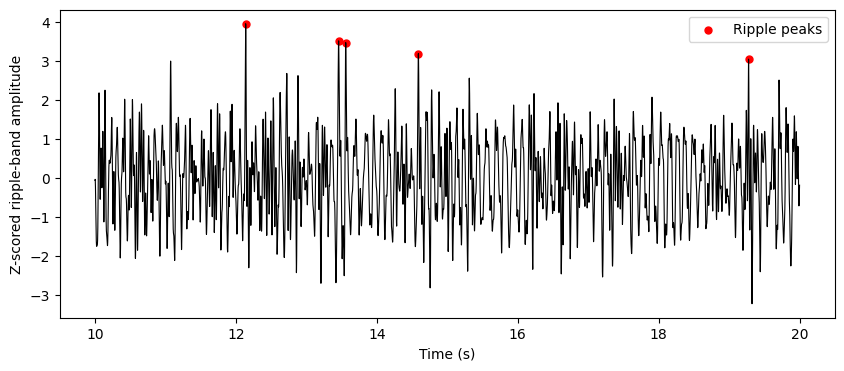

In [14]:
# 1. Filter LFP
filtered = butter_bandpass_filter(
    -lfp[2,:], lowcut=5, highcut=40, fs=fs, order_hp=2, order_lp=4, axis=-1
)

# 2. Z-score
zsig = (filtered - np.mean(filtered)) / np.std(filtered)
plt.figure(figsize=(10, 4))
plot_ripple_overview(
    lfp_z=zsig, ripples_df=sw_df, fs=fs, time_window=(10, 20)
)
plt.show()

In [29]:

# Apply to each ripple
ripples_minima[['spw_index', 'peak_offset_ms', 'overlap_ms']] = ripples_minima.apply(
    find_spw_overlap, axis=1, df_spw=sw_df
)
ripples_minima['has_spw'] = ripples_minima['spw_index'].notna()

print(ripples_minima["has_spw"].value_counts())
ripples_minima

has_spw
False    2087
True      755
Name: count, dtype: int64


,peak_idx,peak_amp,start_idx,end_idx,start_time,peak_time,end_time,duration_ms,spw_index,peak_offset_ms,overlap_ms,has_spw
0,1718,3.124803,1638,1868,0.6552,0.6872,0.7472,92.0,NaN,NaN,0.0,False
1,3367,3.113185,3251,3473,1.3004,1.3468,1.3892,88.8,NaN,NaN,0.0,False
2,5865,3.729443,5756,6003,2.3024,2.3460,2.4012,98.8,NaN,NaN,0.0,False
3,9593,3.038983,9443,9682,3.7772,3.8372,3.8728,95.6,NaN,NaN,0.0,False
4,21954,3.063064,21879,22074,8.7516,8.7816,8.8296,78.0,NaN,NaN,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2837,17489824,4.202886,17489643,17489937,6995.8572,6995.9296,6995.9748,117.6,NaN,NaN,0.0,False
2838,17490603,3.808734,17490256,17490662,6996.1024,6996.2412,6996.2648,162.4,3416.0,10.8,45.2,True
2839,17490686,3.071225,17490662,17490806,6996.2648,6996.2744,6996.3224,57.6,3416.0,-22.4,7.6,True
2840,17491731,3.243417,17491629,17491962,6996.6516,6996.6924,6996.7848,133.2,3419.0,8.0,39.6,True


In [31]:
ripples_minima.loc[ripples_minima["has_spw"], :]

,peak_idx,peak_amp,start_idx,end_idx,start_time,peak_time,end_time,duration_ms,spw_index,peak_offset_ms,overlap_ms,has_spw
7,33652,3.652149,33538,33801,13.4152,13.4608,13.5204,105.2,3.0,-3.2,54.4,True
12,83629,3.352213,83462,83769,33.3848,33.4516,33.5076,122.8,12.0,2.4,27.2,True
21,125328,3.015752,125241,125597,50.0964,50.1312,50.2388,142.4,17.0,3.2,49.6,True
82,526112,3.802350,525996,526250,210.3984,210.4448,210.5000,101.6,66.0,-10.0,52.8,True
88,586909,3.624585,586785,587055,234.7140,234.7636,234.8220,108.0,70.0,-10.8,56.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2833,17478572,4.058530,17478454,17478652,6991.3816,6991.4288,6991.4608,79.2,3407.0,0.0,40.8,True
2834,17482640,7.934794,17482502,17482912,6993.0008,6993.0560,6993.1648,164.0,3409.0,-4.4,49.2,True
2838,17490603,3.808734,17490256,17490662,6996.1024,6996.2412,6996.2648,162.4,3416.0,10.8,45.2,True
2839,17490686,3.071225,17490662,17490806,6996.2648,6996.2744,6996.3224,57.6,3416.0,-22.4,7.6,True


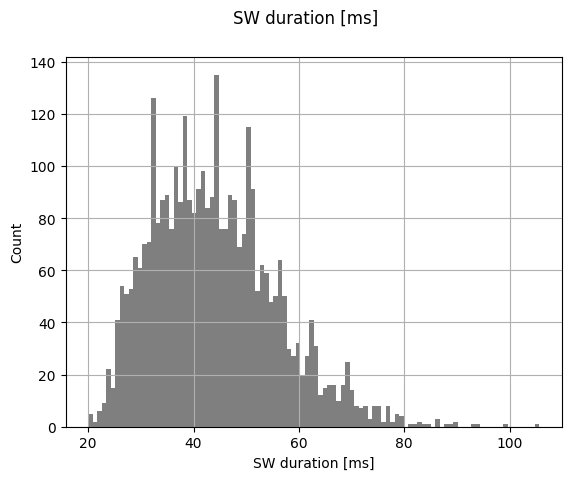

In [16]:
plt.figure()
sw_df["duration_ms"].hist(bins=100, color="k", alpha=.5)
plt.xlabel("SW duration [ms]")
plt.ylabel("Count")
plt.suptitle("SW duration [ms]")
plt.show()

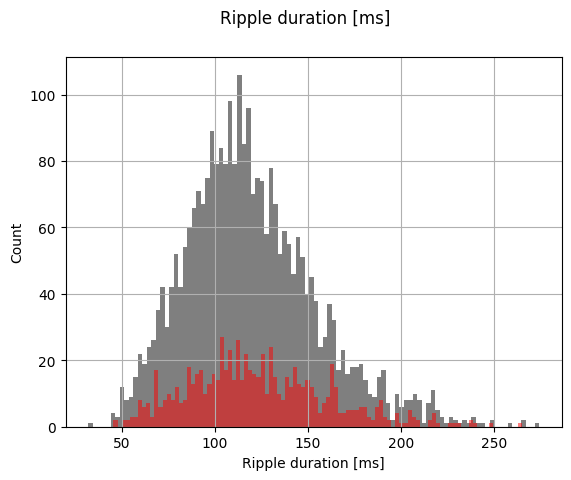

In [17]:
plt.figure()
ripples_minima["duration_ms"].hist(bins=100, color="k", alpha=.5)
ripples_minima.loc[ripples_minima["has_spw"], "duration_ms"].hist(bins=100, color="r", alpha=.5)
plt.xlabel("Ripple duration [ms]")
plt.ylabel("Count")
plt.suptitle("Ripple duration [ms]")
plt.show()

In [18]:
755 / (lfp.shape[1] / fs), 755/2800, 755/3400

(0.10780460197427208, 0.26964285714285713, 0.22205882352941175)

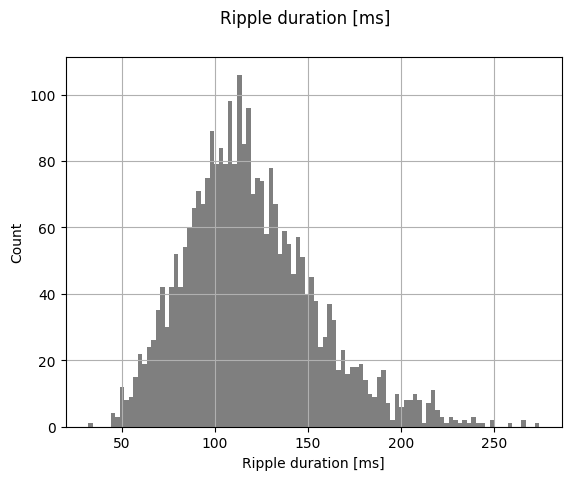

In [19]:
plt.figure()
ripples_minima["duration_ms"].hist(bins=100, color="k", alpha=.5)
plt.xlabel("Ripple duration [ms]")
plt.ylabel("Count")
plt.suptitle("Ripple duration [ms]")
plt.show()

Examples for plotting

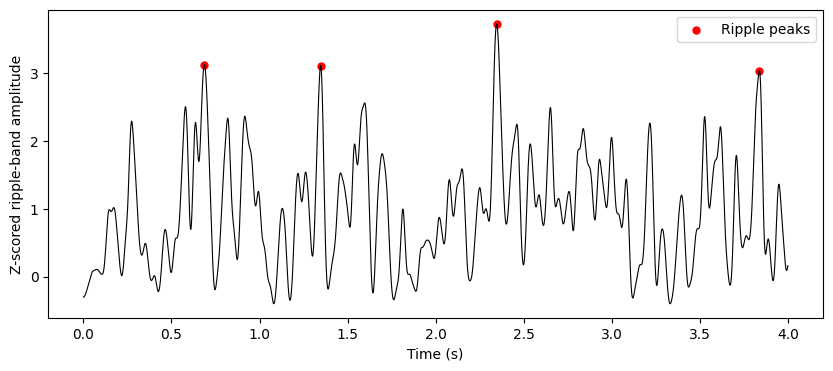

In [20]:
plot_ripple_overview(
    lfp_z=lfp_z, ripples_df=ripples_minima, fs=fs, time_window=(0, 4)
)
plt.show()


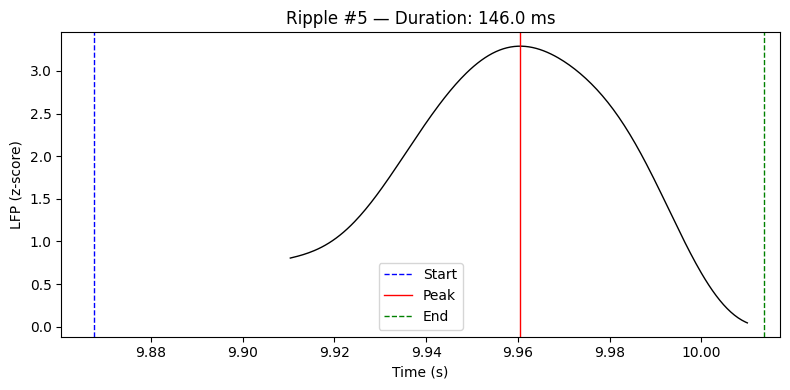

In [21]:
# Plot one ripple (e.g. index 5)
plot_single_ripple(
    lfp_z=lfp_z, ripples_df=ripples_minima, event_idx=5, fs=fs
)
plt.show()


#### Ripple-triggered averages in sharp-wave LFP band

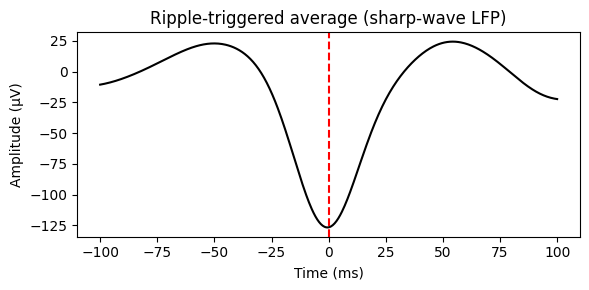

In [22]:
# Filter LFP for sharp-wave band 1-30Hz & average window at ripple timepoints.
lfp_sw = butter_bandpass_filter(
    data=lfp, lowcut=1, highcut=30, fs=fs, axis=-1
)
t_rta, avg_sw = ripple_triggered_average(
    lfp_sw, ripples_minima, fs=fs, window_ms=100
)

# Plot
plt.figure(figsize=(6, 3))
plt.plot(
    t_rta, np.mean(avg_sw, axis=0) * 0.195, color="k"
)  # .195 is the scaling for openephys acquisition system
plt.title("Ripple-triggered average (sharp-wave LFP)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.axvline(0, color="r", ls="--")
plt.tight_layout()
plt.show()



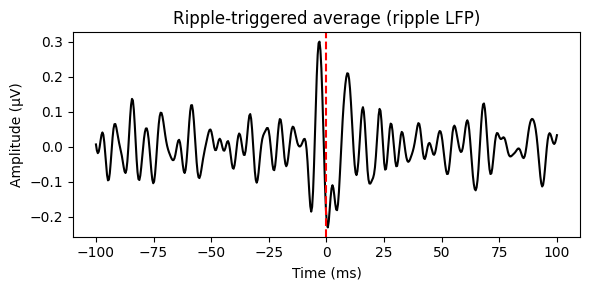

In [23]:
t_rta_rpl, avg_rpl = ripple_triggered_average(
    lfp_ripple, ripples_minima, fs=fs, window_ms=100
)

# Plot
plt.figure(figsize=(6, 3))
plt.plot(
    t_rta_rpl, np.mean(avg_rpl, axis=0) * 0.195, color="k"
)  # .195 is the scaling for openephys acquisition system
plt.title("Ripple-triggered average (ripple LFP)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.axvline(0, color="r", ls="--")
plt.tight_layout()
plt.show()

/tmp/ipykernel_813922/4043745800.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


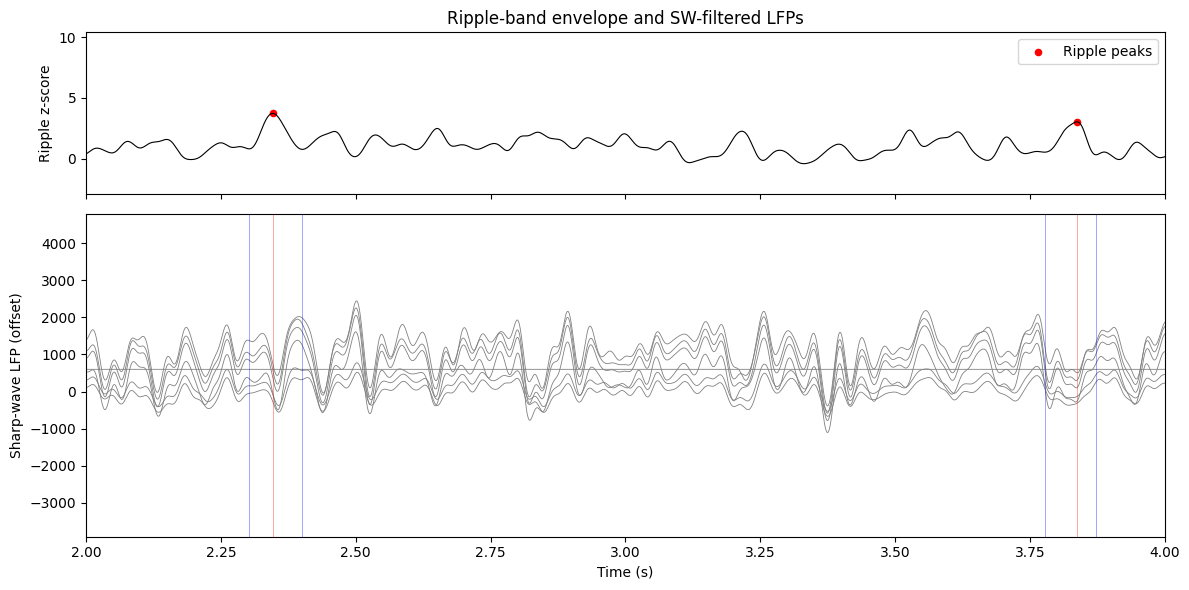

In [24]:
# Ripple detection trace + sharp-wave LFP
plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=lfp_sw,
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(2, 4),
)
plt.show()


/tmp/ipykernel_813922/4043745800.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


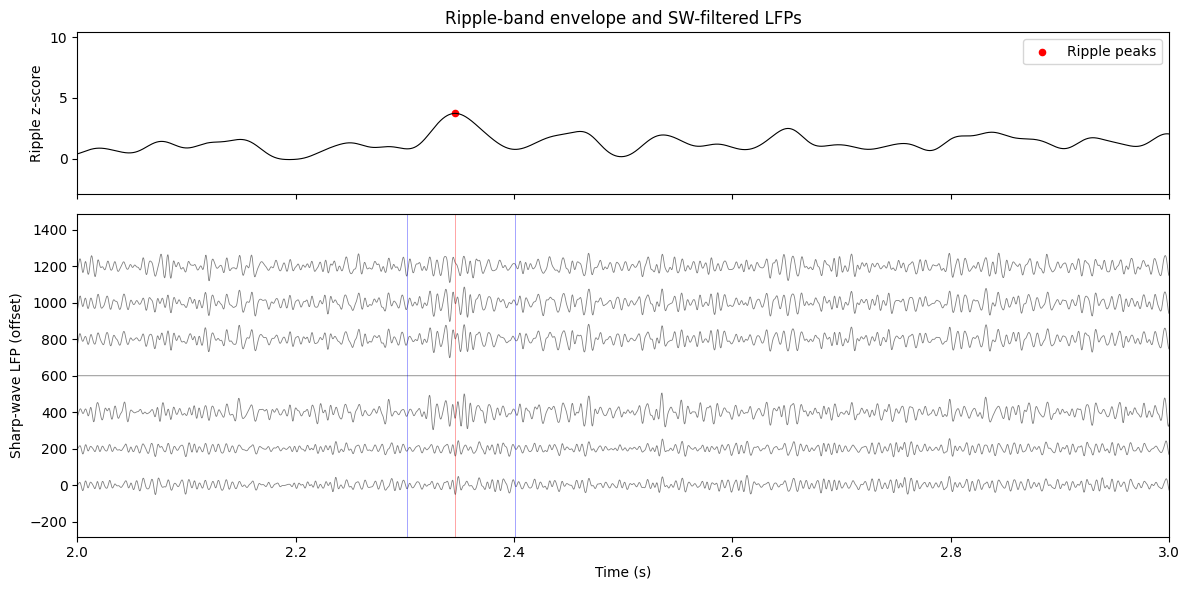

In [27]:
# Ripple detection trace + ripple LFP
plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=lfp_ripple,
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(2, 3),
)
plt.show()

/tmp/ipykernel_813922/4043745800.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/tars/miniconda3/envs/db/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


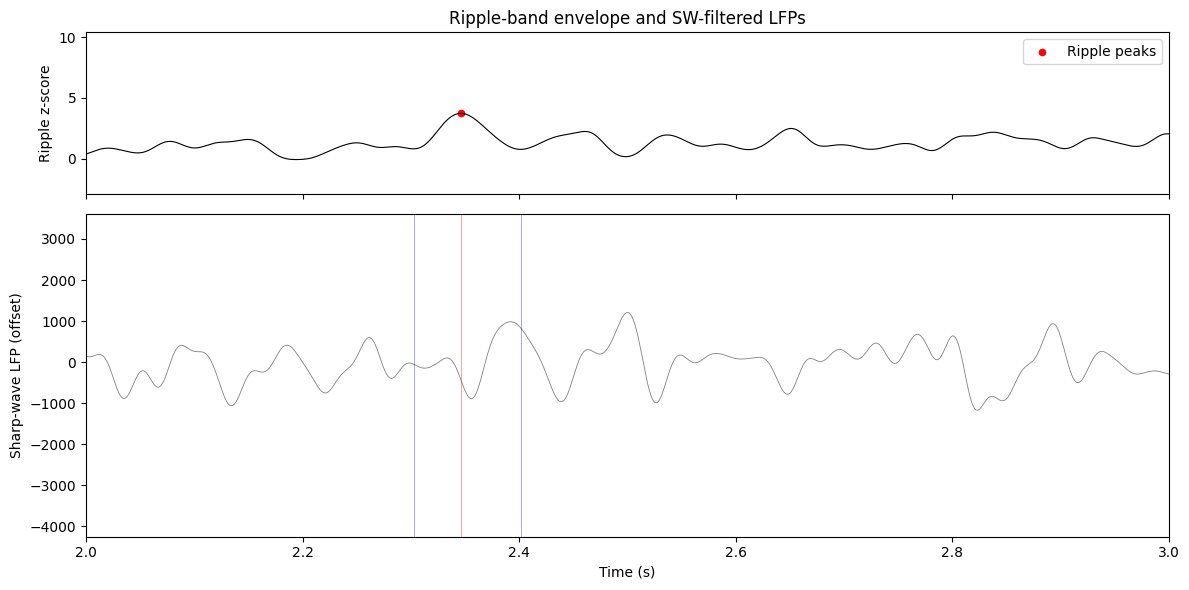

In [28]:
# Ripple detection + LFP that shows overlay of ripple with sharp-wave in same band
plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=(lfp_sw)[2:3,:],
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(2, 3),
)
plt.show()

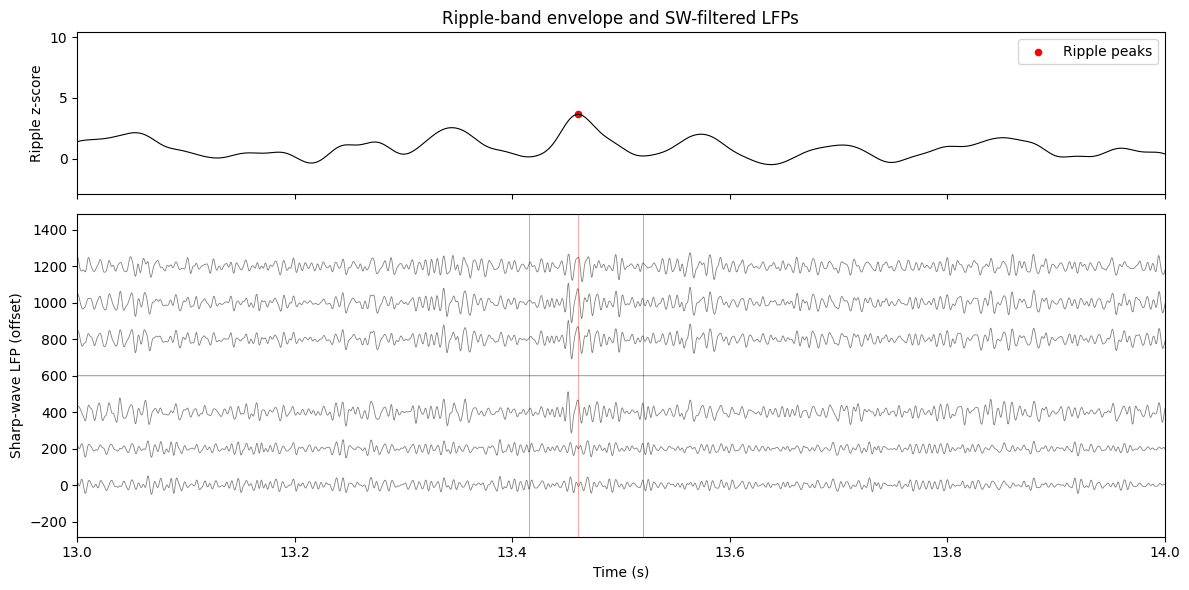

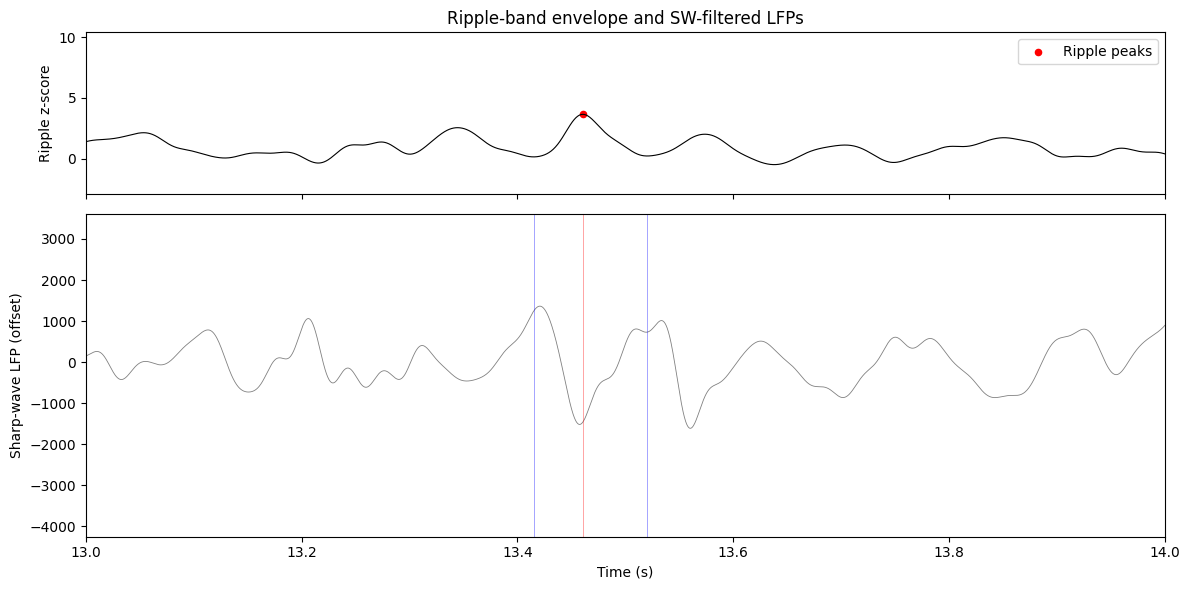

In [32]:
# ripple + SW

t_start = 13
t_end = 14

# Ripple detection trace + ripple LFP
plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=lfp_ripple,
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(t_start, t_end),
)

plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=(lfp_sw)[2:3,:],
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(t_start, t_end),
)

plt.show()

/tmp/ipykernel_813922/4043745800.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/tars/miniconda3/envs/db/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


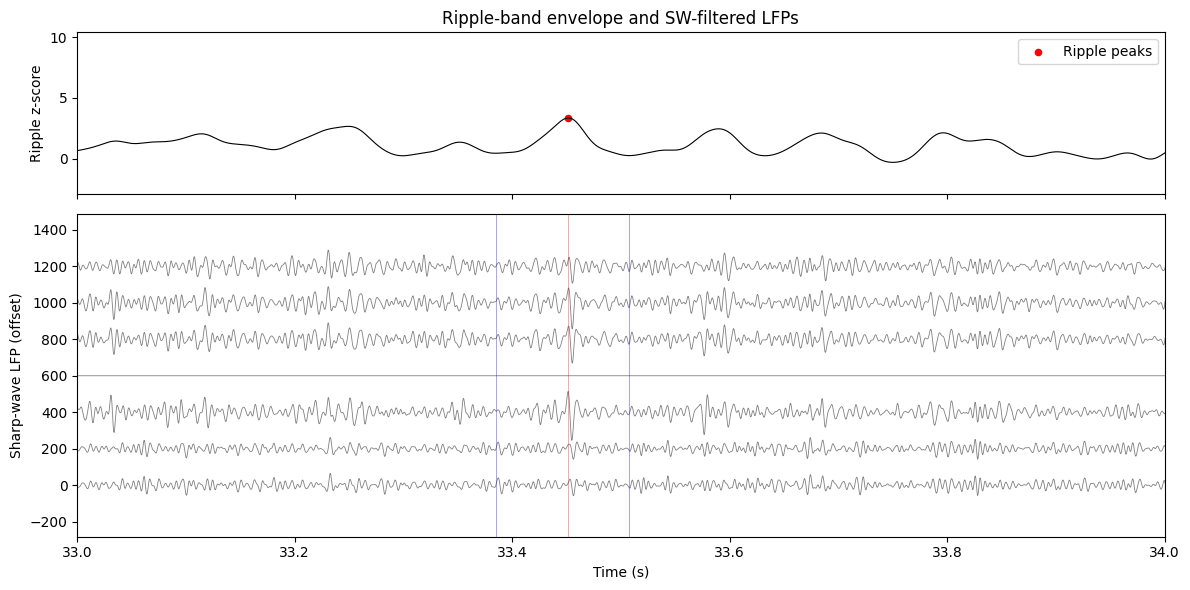

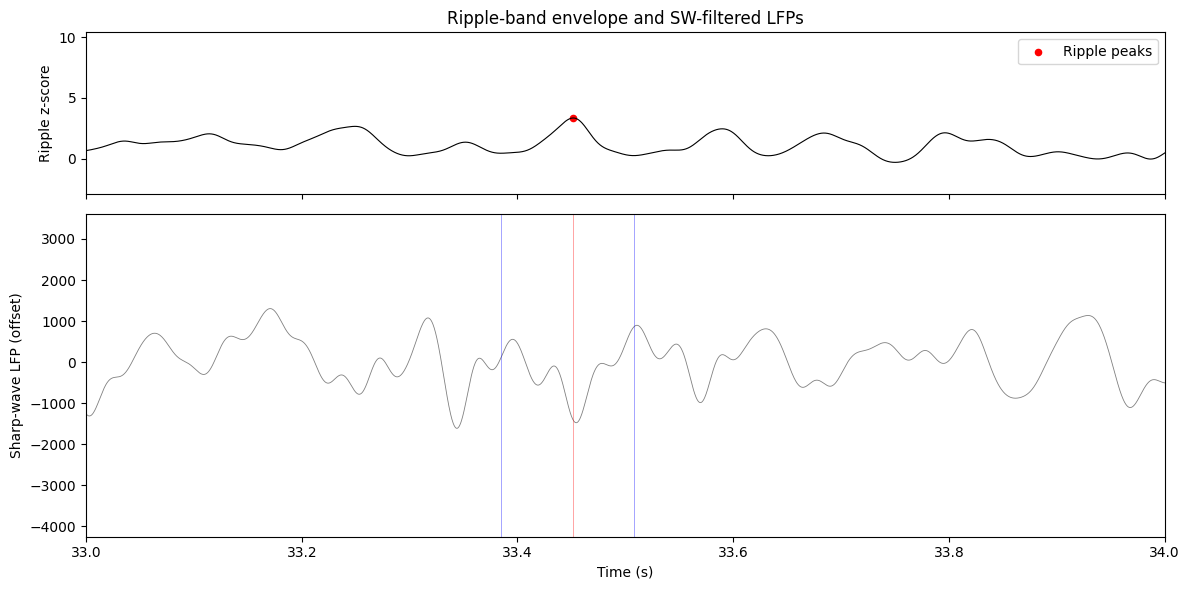

In [34]:
# ripple + SW

t_start = 33
t_end = 34

# Ripple detection trace + ripple LFP
plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=lfp_ripple,
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(t_start, t_end),
)

plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=(lfp_sw)[2:3,:],
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(t_start, t_end),
)

plt.show()

/tmp/ipykernel_813922/4043745800.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_813922/4043745800.py:245: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


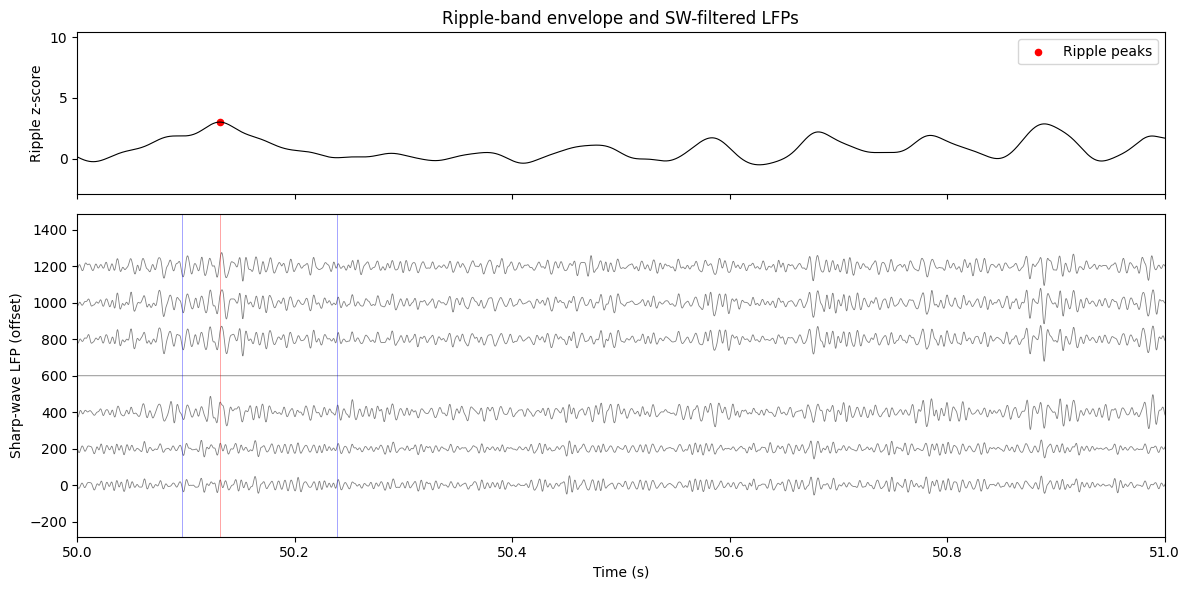

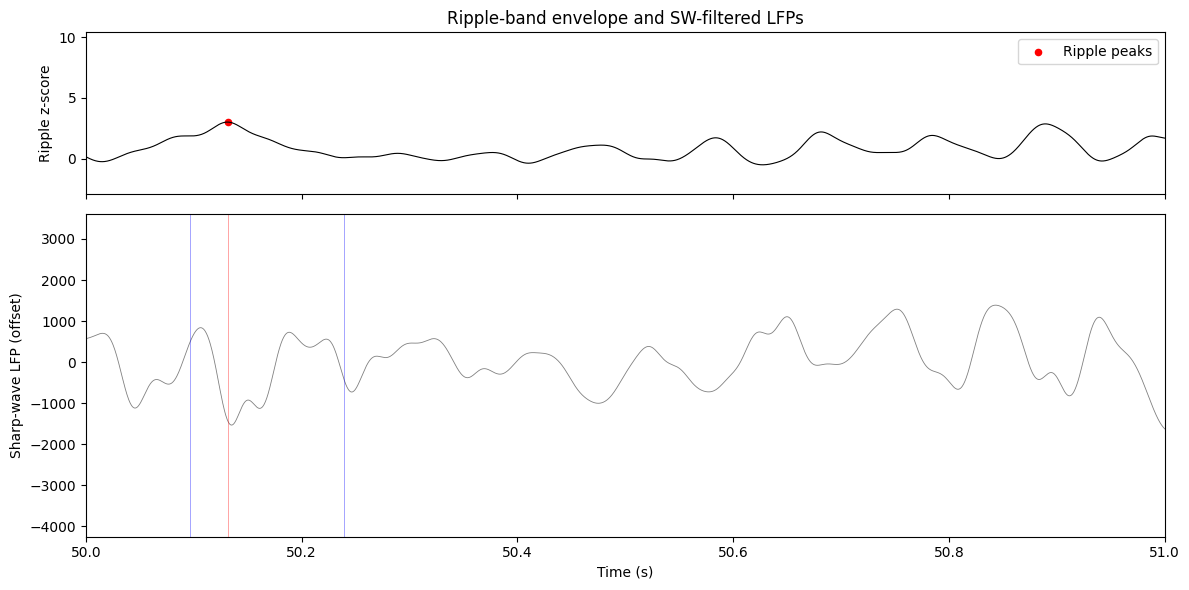

In [35]:
# ripple + SW

t_start = 50
t_end = 51

# Ripple detection trace + ripple LFP
plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=lfp_ripple,
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(t_start, t_end),
)

plot_ripple_triggered_lfp(
    lfp_z=lfp_z,
    lfp_sw=(lfp_sw)[2:3,:],
    ripple_df=ripples_minima,
    fs=fs,
    xlim=(t_start, t_end),
)

plt.show()